In [1]:
import os
import shutil
import keras
import numpy as np
import pandas as pd
from keras import models
from keras.layers import *
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.preprocessing.image import ImageDataGenerator

In [2]:
model = MobileNetV2(include_top=False, weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
shutil.copy("/content/gdrive/MyDrive/Data.zip", "/content/Dataset/")

'/content/Dataset/Data.zip'

In [ ]:
!unzip /content/Dataset/Data.zip

### Creating train and val generator

In [9]:
train_gen = ImageDataGenerator(rescale=1/255.0,
                               rotation_range=40, 
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.3,
                               shear_range=0.2,
                               horizontal_flip=True
                                )
val_gen = ImageDataGenerator(rescale=1/255.0)

In [10]:
train_generator = train_gen.flow_from_directory('Train/',
                                               target_size=((224, 224)),
                                               batch_size=32,
                                               class_mode='categorical'
                                               )
val_generator = val_gen.flow_from_directory('val_images/',
                                               target_size=((224, 224)),
                                               batch_size=32,
                                               class_mode='categorical'
                                               )

Found 1473 images belonging to 10 classes.
Found 169 images belonging to 10 classes.


In [9]:
print(train_generator.class_indices, val_generator.class_indices, sep='\n')

{'Aerodactyl': 0, 'Bulbasaur': 1, 'Charmander': 2, 'Dratini': 3, 'Fearow': 4, 'Meowth': 5, 'Pikachu': 6, 'Psyduck': 7, 'Spearow': 8, 'Squirtle': 9}
{'Aerodactyl': 0, 'Bulbasaur': 1, 'Charmander': 2, 'Dratini': 3, 'Fearow': 4, 'Meowth': 5, 'Pikachu': 6, 'Psyduck': 7, 'Spearow': 8, 'Squirtle': 9}


### Preparing the model by fine tuning

In [19]:
model = models.Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)))
model.add(MaxPool2D(2,2))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10,activation='softmax'))

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 128)      

In [22]:
model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])

In [23]:
# Save the checkpoint in the /output folder
filepath = "/output/best.hdf5"

# Keep only a single checkpoint, the best over test accuracy.
checkpoint = ModelCheckpoint(filepath,
                            monitor='val_accuracy',
                            verbose=1,
                            save_best_only=True,
                            mode='max')

In [24]:
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=47,
    epochs=60,
    validation_data=val_generator,
    validation_steps=6,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/60


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


47/47 [==============================] - 46s 954ms/step - loss: 2.1042 - accuracy: 0.3298 - val_loss: 2.1723 - val_accuracy: 0.1834

Epoch 00001: val_accuracy improved from -inf to 0.18343, saving model to /output/best.hdf5
Epoch 2/60
47/47 [==============================] - 44s 931ms/step - loss: 1.4743 - accuracy: 0.5209 - val_loss: 2.1071 - val_accuracy: 0.3018

Epoch 00002: val_accuracy improved from 0.18343 to 0.30178, saving model to /output/best.hdf5
Epoch 3/60
47/47 [==============================] - 44s 934ms/step - loss: 1.3129 - accuracy: 0.5752 - val_loss: 2.0364 - val_accuracy: 0.3136

Epoch 00003: val_accuracy improved from 0.30178 to 0.31361, saving model to /output/best.hdf5
Epoch 4/60
47/47 [==============================] - 44s 916ms/step - loss: 1.2345 - accuracy: 0.6318 - val_loss: 2.0187 - val_accuracy: 0.3846

Epoch 00004: val_accuracy improved from 0.31361 to 0.38462, saving model to /output/best.hdf5
Epoch 5/60
47/47 [==============================] - 44s 937ms/

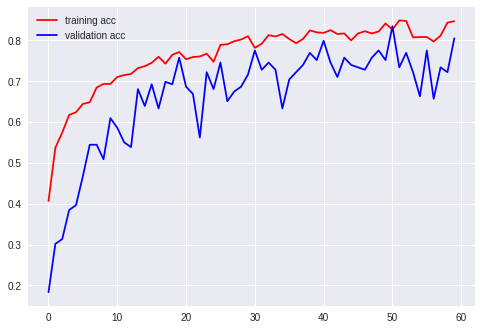

In [25]:
plt.style.use("seaborn")

plt.plot(hist.history['accuracy'],label="training acc",c='red')
plt.plot(hist.history['val_accuracy'],label="validation acc",c='blue')
plt.legend()
plt.show()

## Loading test data and Getting predictions

In [26]:
path = "Test/"
y_df = pd.read_csv(path+"sample_submission.csv")
y_df.shape

(187, 2)

In [27]:
y_df.head()

,Name,Class
0,test_32.jpg,0
1,test_147.jpg,0
2,test_171.jpg,0
3,test_114.jpg,0
4,test_162.jpg,0


In [28]:
y_df.drop(['Class'],inplace=True,axis=1)

In [29]:
y_df=y_df.values.reshape((-1,))
print(y_df.shape)

(187,)


In [30]:
from pathlib import Path
pi_test=Path("Test/images/")

image_data_test=[]
label_test=[]

for image_path in pi_test.glob("*"):
    label=(str(image_path).split("/")[-1])
    img=image.load_img(image_path,target_size=(224,224,3))
    image_array=image.img_to_array(img)/255.0
    image_data_test.append(image_array)
    label_test.append(label)

In [31]:
image_data_test=np.array(image_data_test)

In [32]:
print(image_data_test.shape, len(label_test), sep='\n')

(187, 224, 224, 3)
187


In [33]:
y_predicted=model.predict_classes(image_data_test)
y_predicted

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 4, 1, 5, 9, 2, 6, 6, 1, 6, 2, 5, 1, 7, 2, 6, 6, 6, 2, 6, 1, 5,
       0, 8, 9, 6, 4, 6, 2, 7, 9, 4, 9, 6, 3, 9, 3, 5, 1, 2, 3, 6, 3, 5,
       4, 1, 1, 1, 1, 8, 2, 6, 2, 6, 1, 9, 2, 7, 5, 9, 4, 8, 1, 7, 4, 3,
       1, 8, 7, 7, 1, 0, 5, 2, 1, 1, 9, 1, 2, 8, 2, 9, 9, 4, 1, 3, 2, 9,
       7, 5, 9, 1, 7, 7, 8, 6, 2, 6, 9, 1, 8, 1, 9, 2, 2, 1, 1, 6, 7, 1,
       9, 3, 9, 1, 7, 6, 3, 9, 6, 6, 5, 1, 9, 5, 1, 2, 6, 2, 6, 8, 1, 7,
       7, 9, 1, 9, 0, 8, 7, 7, 1, 2, 6, 5, 9, 6, 5, 9, 5, 7, 4, 6, 8, 9,
       6, 4, 8, 1, 7, 0, 6, 9, 0, 9, 4, 1, 9, 2, 0, 2, 4, 1, 0, 0, 1, 2,
       8, 2, 2, 2, 2, 6, 9, 1, 7, 2, 8])

In [34]:
y_pre=[]
for i in range(image_data_test.shape[0]):
    index=label_test.index(y_df[i])
    y=y_predicted[index]
    y_pre.append((y_df[i],y))

In [35]:
y_pre=np.array(y_pre)

In [36]:
df_pre=pd.DataFrame(data=y_pre,columns=['Name','Class'])

In [37]:
df_pre.to_csv('y_predict_of_pokedex_learning_own_features1.csv',index=False)